# Предсказание рейтинга фильма

## Описание набора данных и признаков

### Описан процесс сбора данных

Данные взяты из <a href="https://www.imdb.com/interfaces/">IMDb</a> 2 апреля 2018 года. Источник обновляет данные ежедневно. Если вы желаете взять именно те данные, которые использованы в этой работе, скачать их можно <a href="https://yadi.sk/d/m1aE5pkQ3UeVpJ">здесь</a> (~3 Gb).

### Подробное описание решаемой задачи, ее ценности

Перед моделью стоит задача регрессии — предсказать рейтинг фильма на основе данных о нем.<br/>
Напрямую модель можно использовать в том случае, когда у нового фильма (по вашей оценке) пока недостаточно голосов для получения достоверного рейтинга, но уже известны значения признаков. Или в том случае, когда вы только собираете команду для создания фильма из известных в индустрии профессионалов, а так же выбираете название фильма :)

### Описание целевого и прочих признаков

Каждый датасет хранится в .tsv формате в UTF-8 кодировке. Первая строка — заголовки. Символ `'\N'` используется для обозначения отсутствующей информации в определенном поле.

Список датасетов и описание полей в них ниже. Здесь и далее под произведениями я понимаю полнометражные и короткометражные фильмы, сериалы, видео и другие типы контента, опубликованного на IMDb.

title.basics.tsv.gz - содержит следующую информацию о произведениях:

    tconst (string) - численно-буквенный уникальный идентификатор произведения
    titleType (string) – тип/формат произведения (например, 'movie', 'short', 'tvseries' и т. д.)
    primaryTitle (string) – наиболее популярное название / название, использованное авторами в промо-материалах релиза
    originalTitle (string) - оригинальное название на оригинальном языке
    isAdult (boolean) - 0: для всех; 1: только для взрослых
    startYear (YYYY) – год релиза. Для сериалов это год релиза первой серии
    endYear (YYYY) – год последней серии (используется для сериалов). ‘\N’ для всех остальных типов/форматов
    runtimeMinutes – продолжительность в минутах
    genres (string array) – до трех (включительно) жанров, соответствующих произведению

title.crew.tsv.gz – информация о режиссерах и сценаристах:

    tconst (string) - численно-буквенный уникальный идентификатор произведения
    directors (array of nconsts) - режиссер(ы)
    writers (array of nconsts) – сценарист(ы)

title.principals.tsv.gz – информация о командах, участвующих в создании произведений:

    tconst (string) - численно-буквенный уникальный идентификатор произведения
    principalCast (array of nconsts) – наиболее высокооплачиваемые участники

title.ratings.tsv.gz – рейтинг IMDb и количество голосов:

    tconst (string) - численно-буквенный уникальный идентификатор произведения
    averageRating – взвешенное среднее индивидуальных голосов пользователей
    numVotes - количество голосов

### Чтение и предобработка данных

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import normaltest, skewtest, probplot, boxcox
from scipy.sparse import hstack, vstack

from sklearn.model_selection import train_test_split,\
                                    GridSearchCV,\
                                    KFold,\
                                    validation_curve,\
                                    learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

#### Чтение данных

In [2]:
PATH_TO_DATA = './data/'

titles_df = pd.read_csv(PATH_TO_DATA + 'title.basics.tsv/data.tsv',
                              sep='\t',
                              dtype=str,
                              na_values=['\\N'])

ratings_df = pd.read_csv(PATH_TO_DATA + 'title.ratings.tsv/data.tsv',
                         sep='\t',
                         dtype=str,
                         na_values=['\\N'])

crews_df = pd.read_csv(PATH_TO_DATA + 'title.crew.tsv/data.tsv',
                      sep='\t',
                      dtype=str,
                      na_values=['\\N'])

principals_df = pd.read_csv(PATH_TO_DATA + 'title.principals.tsv/data.tsv',
                            sep='\t',
                            dtype=str,
                            na_values=['\\N'])

#### Предобработка данных

In [3]:
# Уберем все объекты, у которых нет нужных данных.
titles_df.drop(
    index=titles_df[(titles_df['originalTitle'].isnull()) |\
                    (titles_df['startYear'].isnull()) |\
                    (titles_df['genres'].isnull()) |\
                    (titles_df['runtimeMinutes'].isnull())
                   ].index,
    axis=0,
    inplace=True)
# И уберем лишние данные
titles_df.drop('originalTitle', axis=1, inplace=True)

In [4]:
# Заполняю пропуски, привожу к нужным типам.
titles_df['isAdult'] = titles_df['isAdult'].astype(int)
titles_df['endYear'].fillna(0, inplace=True)
titles_df['startYear'] = titles_df['startYear'].astype(int)
titles_df['runtimeMinutes'] = titles_df['runtimeMinutes'].astype(int)

ratings_df['averageRating'] = ratings_df['averageRating'].astype(float)
ratings_df['numVotes'] = ratings_df['numVotes'].astype(int)

In [5]:
# Делаем аналог INNER JOIN для данных по фильму и рейтингам фильмов.
df = pd.merge(titles_df, ratings_df, how='inner', on='tconst')

In [6]:
%%time

# Составляю список уникальных жанров, он нам понадобится позже.
unique_genres = set(','.join(df['genres']).split(','))

# А это ручной аналог OHE, без необходимости использовать Label Encoder.
# Довольно долго вычисляет (~12 секунд), т. к. проходим по всей выборке
# столько раз, сколько у нас жанров. Но с данными в таком виде
# мне было проще работать в дальнейшем.

for curr_genre in unique_genres:
    df[curr_genre] = df['genres'].map(
        lambda r: 1 if curr_genre in r.split(',') else 0)

Wall time: 12.5 s


In [7]:
# Опять делаем аналог INNER JOIN,
# на этот раз — с данными о режиссерах и сценаристах.
df = pd.merge(df, crews_df, how='inner', on='tconst')

# Заполняем пропуски.
df['directors'].fillna('', inplace=True)
df['writers'].fillna('', inplace=True)

In [8]:
# В principals_df уникальный идентификатор произведения может
# встречаться много раз, и каждый раз с новым участником.
# Объединяю их всех в одну строку через запятую.
principals_by_title_df =\
    principals_df[['tconst',
                   'nconst']].groupby('tconst').agg(','.join).reset_index()

# И снова делаю INNER JOIN с этими данными.
df = pd.merge(df, principals_by_title_df, how='inner', on='tconst')
df = df.rename({'nconst': 'principals'}, axis=1)

## Первичный анализ данных, включая визуальный

#### Типы признаков

Посмотрим, с какими признаками мы имеем дело.
В `df` присутствуют:

- 31 категориальный признак (`[tconst, titleType, isAdult]` и 28 жанров)
- 5 количественных признаков, считая целевой (`[startYear, endYear, runtimeMinutes, numVotes, averageRating]`)
- 3 признака, содержащие тексты (`[primaryTitle, directors, writes]`). Их с помощью OHE я переведу в разреженную матрицу с категориальными признаками.

#### Пропуски в данных

In [9]:
missing_values_count = df.isnull().sum()

print("Из {} объектов данные пропущены у {} объектов.\n\
Потому что выше я заполнил пропуски, а так же убрал объекты \
без минимально необходимого набора данных.\nСчитаю это возможным, \
т. к. данных все равно осталось более полумиллиона."
      .format(df.shape[0], missing_values_count.sum()))

Из 566006 объектов данные пропущены у 0 объектов.
Потому что выше я заполнил пропуски, а так же убрал объекты без минимально необходимого набора данных.
Считаю это возможным, т. к. данных все равно осталось более полумиллиона.


In [10]:
print("Данные о годе последней серии указаны у {} произведений"
      .format(df[df['endYear']!=0]['tconst'].count()))

print("Данные о режиссерах отсутствуют у {} произведений"
      .format(df[df['directors']=='']['tconst'].count()))

print("Данные о сценаристах отсутствуют у {} произведений"
      .format(df[df['writers']=='']['tconst'].count()))

Данные о годе последней серии указаны у 10672 произведений
Данные о режиссерах отсутствуют у 40077 произведений
Данные о сценаристах отсутствуют у 85600 произведений


#### Выбросы в данных

In [11]:
df.loc[:, [dc for dc in df.columns if dc not in list(unique_genres)]].describe()

,isAdult,startYear,runtimeMinutes,averageRating,numVotes
count,566006.000000,566006.000000,566006.000000,566006.000000,5.660060e+05
mean,0.019710,1995.915526,57.987113,6.881785,1.412171e+03
std,0.139002,21.914931,52.092822,1.347251,1.844339e+04
min,0.000000,1878.000000,0.000000,1.000000,5.000000e+00
25%,0.000000,1986.000000,23.000000,6.100000,1.100000e+01
50%,0.000000,2005.000000,49.000000,7.100000,3.100000e+01
75%,0.000000,2012.000000,89.000000,7.800000,1.330000e+02
max,1.000000,2018.000000,14400.000000,10.000000,1.933861e+06


Видно, что потенциальные кандидаты на отнесение к выбросам находятся в колонках `runtimeMinutes` и `numVotes`. Посмотрим на них поближе.

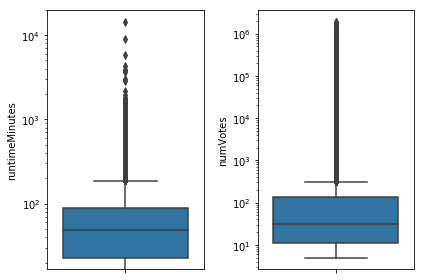

In [12]:
plt.subplot(1, 2, 1)
sns.boxplot(df['runtimeMinutes'], orient='v')
plt.yscale('log')
plt.subplot(1, 2, 2)
sns.boxplot(df['numVotes'], orient='v')
plt.yscale('log')
plt.tight_layout();

Действительно, объекты, которые можно посчитать выбросами, явно присутствуют. Посмотрим, сколько их.

In [13]:
df[['runtimeMinutes', 'numVotes']].describe(percentiles=[0.8, 0.95, 0.99, 0.999])

,runtimeMinutes,numVotes
count,566006.000000,5.660060e+05
mean,57.987113,1.412171e+03
std,52.092822,1.844339e+04
min,0.000000,5.000000e+00
50%,49.000000,3.100000e+01
80%,92.000000,2.000000e+02
95%,120.000000,1.743750e+03
99%,180.000000,2.026345e+04
99.9%,400.000000,2.439414e+05
max,14400.000000,1.933861e+06


Они составляют меньше процента. Посмотрим, является ли это ошибкой или такова природа данных.

In [14]:
df.sort_values(by=['runtimeMinutes'],
               ascending=False
              ).iloc[:5].loc[:, [dc for dc in df.columns if dc not in list(unique_genres)]]

,tconst,titleType,primaryTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,principals
437896,tt2659636,movie,Modern Times Forever,0,2011,0,14400,Documentary,6.3,65,"nm5492495,nm5492599,nm1432536,nm5492891",,"nm5492599,nm5492495,nm5492891,nm1432536"
422580,tt2355497,movie,Beijing 2003,0,2004,0,9000,Documentary,7.1,9,nm2675885,,nm2675885
561171,tt7357138,tvMovie,Katy Perry Live: Witness World Wide,0,2017,0,5760,"Music,Reality-TV",8.3,6,nm3632964,,"nm0420941,nm2953537,nm0085438,nm0158632,nm0179..."
562791,tt7538778,movie,Writing on Snow,0,2017,0,4320,"Drama,War",6.2,8,nm0556301,"nm0556301,nm9380850","nm0154439,nm1586095,nm4821480,nm0648337,nm0906..."
262905,tt0804414,tvSeries,Desire,0,2006,2006,3900,Drama,6.3,241,"nm0192463,nm0227486,nm0248119,nm0942185,nm0324426","nm1548597,nm1919867,nm1107925,nm2352020,nm2358...","nm2272650,nm2259632,nm0018396,nm1497461,nm1925..."


Начнем по порядку, с <a href="https://www.imdb.com/title/tt2659636/" target="_blank">Modern Times Forever (tt2659636)</a>. Как видно, эта картина действительно длится `240h`, или другими словами 14400 / 60 = 240 часов.

Второе в этом списке произведение — <a href="https://www.imdb.com/title/tt2355497/" target="_blank">Beijing 2003 (tt2355497)</a>:
>Runtime approx. 150 hours and one of the longest movies ever made.

Думаю, можно сделать вывод, что таково реальное распределение данных. Поэтому удалять эти объекты не планирую.

In [15]:
df.sort_values(by=['numVotes'],
               ascending=False
              ).iloc[:5].loc[:, [dc for dc in df.columns if dc not in list(unique_genres)]]

,tconst,titleType,primaryTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,principals
70687,tt0111161,movie,The Shawshank Redemption,0,1994,0,142,"Crime,Drama",9.3,1933861,nm0001104,"nm0000175,nm0001104","nm0290358,nm0000209,nm0000151,nm0348409,nm0006..."
180235,tt0468569,movie,The Dark Knight,0,2008,0,152,"Action,Crime,Thriller",9.0,1904272,nm0634240,"nm0634300,nm0634240,nm0333060,nm0004170","nm0746273,nm0000288,nm0005132,nm0001173,nm0000..."
333216,tt1375666,movie,Inception,0,2010,0,148,"Action,Adventure,Sci-Fi",8.8,1691573,nm0634240,nm0634240,"nm0245596,nm0000138,nm0330687,nm0680983,nm0913..."
83560,tt0137523,movie,Fight Club,0,1999,0,139,Drama,8.8,1548344,nm0000399,"nm0657333,nm0880243","nm0513165,nm0000093,nm0001570,nm0001533,nm0340..."
70503,tt0110912,movie,Pulp Fiction,0,1994,0,154,"Crime,Drama",8.9,1510675,nm0000233,"nm0000233,nm0000812","nm0913300,nm0000237,nm0000235,nm0000168,nm0000..."


Первым в списке является известный фильм <a href="https://www.imdb.com/title/tt0111161/" target="_blank">The Shawshank Redemption (tt0111161)</a>. 2 апреля 2018, когда я скачал выгрузку данных, он имел 1,933,861 голосов. С тех пор на сегодня, 19 апреля 2018, проголосовало еще несколько тысяч человек, общее количество — 1,940,993 голосов.

С небольшим отрывом идет фильм <a href="https://www.imdb.com/title/tt0468569/" target="_blank">The Dark Knight (tt0468569)</a>, 1,904,272 голосов на момент скачивания и 1,911,673 на момент проверки.

По названиям следующих фильмов искушенный зритель может сделать предположение, что количество голосов является скорее реальностью, чем ошибкой в данных. Поэтому исключать эти фильмы из выборки не планирую.

#### Анализ признаков

Матрица корреляций для количественных признаков

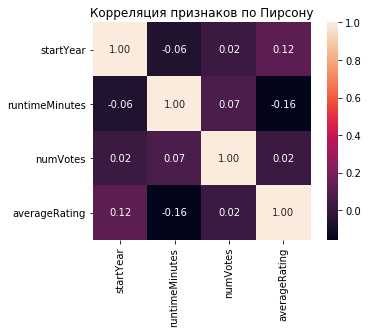

In [16]:
sns.heatmap(df[['startYear',
                'endYear',
                'runtimeMinutes',
                'numVotes',
                'averageRating']].corr(method='pearson'),
            square=True,
            annot=True,
            fmt=".2f")
plt.title('Корреляция признаков по Пирсону');

Видно, что у количественных признаков практически отсутствует корреляция с таргетом.

Хотя можно попробовать использовать год релиза и продолжительность в текущем виде или разбить их на категории.

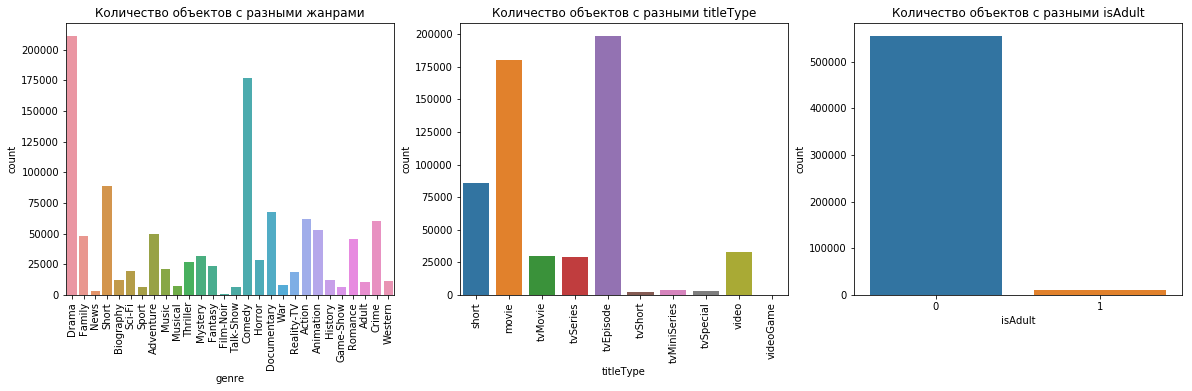

In [17]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
genres_count = df[list(unique_genres)].sum().reset_index()
sns.barplot(genres_count['index'], genres_count[0])
plt.xticks(rotation=90)
plt.title('Количество объектов с разными жанрами')
plt.xlabel('genre')
plt.ylabel('count')

plt.subplot(1, 3, 2)
sns.countplot(df['titleType'])
plt.xticks(rotation=90)
plt.title('Количество объектов с разными titleType')

plt.subplot(1, 3, 3)
sns.countplot(df['isAdult'])
plt.title('Количество объектов с разными isAdult');

Больше всего фильмов имеют жанры Drama и Comedy. С отставанием следуют короткометражки.

Большую часть объектов составляют сериалы, полнометражные фильмы и короткометражки.

И большая часть фильмов не отмечена как "для взрослых" (признак isAdult).

### Исследование распределения целевого признака (в том числе стат-тесты на нормальность и скошенность распределения)

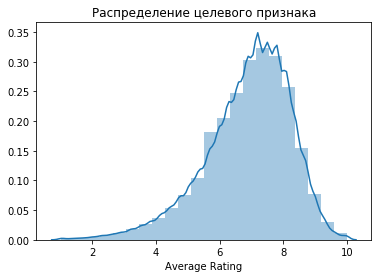

In [18]:
sns.distplot(df['averageRating'], bins=22)
plt.title('Распределение целевого признака')
plt.xlabel('Average Rating');

Тест на нормальность распределения целевого признака

In [19]:
alpha = 1e-2

k2, p = normaltest(df['averageRating'])
print("p = {:.3f}".format(p))

if p < alpha:  # нулевая гипотеза: распределение является нормальным
    print("Нулевая гипотеза может быть отклонена")
else:
    print("Нулевая гипотеза НЕ может быть отклонена")

p = 0.000
Нулевая гипотеза может быть отклонена


Тест на скошенность распределения целевого признака

In [20]:
skewtest(df['averageRating'])

SkewtestResult(statistic=-219.02435557180712, pvalue=0.0)

Видно, что распределение нельзя назвать нормальным. Посмотрим, как выглядит соответствующий график.

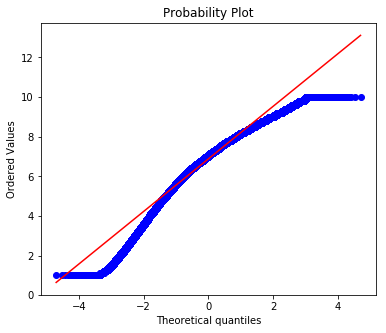

In [21]:
plt.figure(figsize=(6, 5))
probplot(df['averageRating'], dist="norm", plot=plt);

Для задачи регрессии желательно привести распределение к нормальному. Попробуем это сделать. Начнем с логарифмирования.

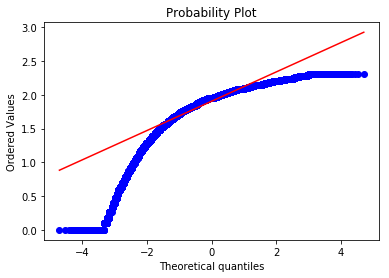

In [22]:
probplot(np.log(df['averageRating']), dist="norm", plot=plt);

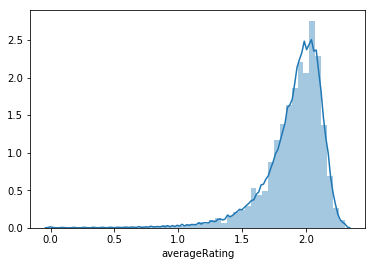

In [23]:
sns.distplot(np.log(df['averageRating']));

Логарифмирование только ухудшило ситуацию. Поскольку мне неизвестно реальное распределение, попробую преобразование Бокса-Кокса.

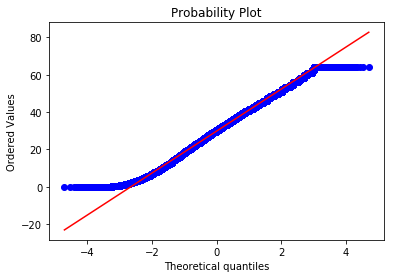

In [24]:
df['bc_avg_rating'], bc_lmbda = boxcox(df['averageRating'])

probplot(df['bc_avg_rating'], dist="norm", plot=plt);

Такое преобразование заметно помогло. Посмотрим на численную оценку.

In [25]:
alpha = 1e-3

k2, p = normaltest(df['bc_avg_rating'])
print("p = {:.3f}".format(p))

if p < alpha:  # нулевая гипотеза: распределение является нормальным
    print("Нулевая гипотеза может быть отклонена")
else:
    print("Нулевая гипотеза НЕ может быть отклонена")

p = 0.000
Нулевая гипотеза может быть отклонена


Распределение не удалось привести к нормальному, но все же мы сдвинулись в эту сторону.

На будущее сделаем преобразование, обратное преобразованию Бокса-Кокса.

In [26]:
def reverse_boxcox(bc_target, bc_lmbda):
    return np.power((bc_target * bc_lmbda) + 1, 1 / bc_lmbda)

Посмотрим теперь на взаимодействия признаков с целевым.

Распределение рейтинга по жанрам.

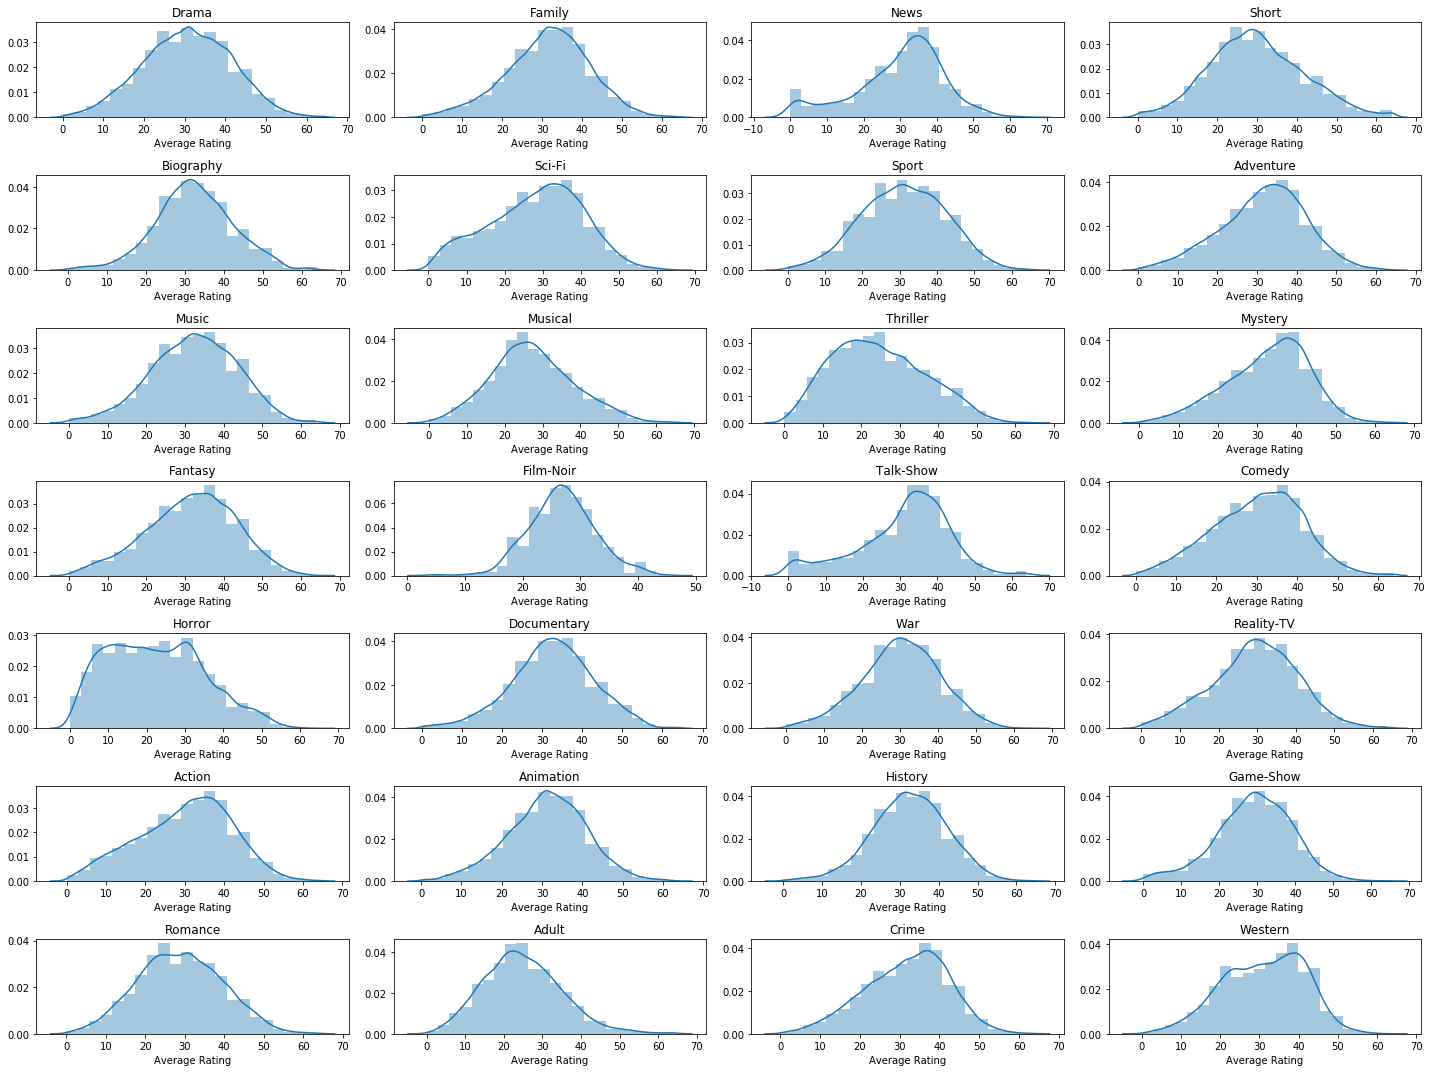

In [27]:
plt.figure(figsize=(20, 15))

for idx, curr_genre in enumerate(unique_genres):
    plt.subplot(7, 4, idx+1)
    plt.title(curr_genre)
    sns.distplot(df[df[curr_genre]==1]['bc_avg_rating'], bins=22)
    plt.xlabel('Average Rating')

plt.tight_layout();

Распределение рейтинга по типу контента.

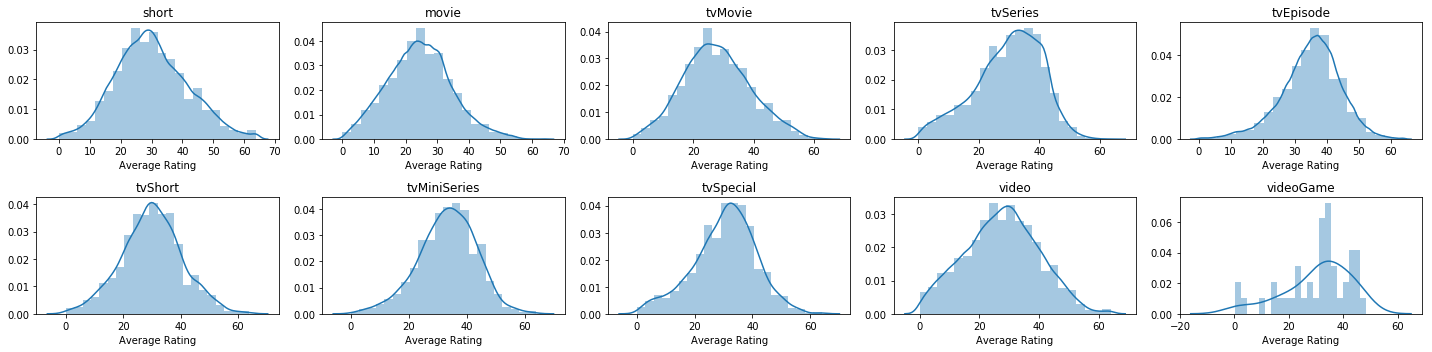

In [28]:
plt.figure(figsize=(20, 5))

for idx, titleType in enumerate(df['titleType'].unique()):
    plt.subplot(2, 5, idx+1)
    plt.title(titleType)
    sns.distplot(df[df['titleType']==titleType]['bc_avg_rating'], bins=22)
    plt.xlabel('Average Rating')

plt.tight_layout();

Зависимость рейтинга от продолжительности контента.

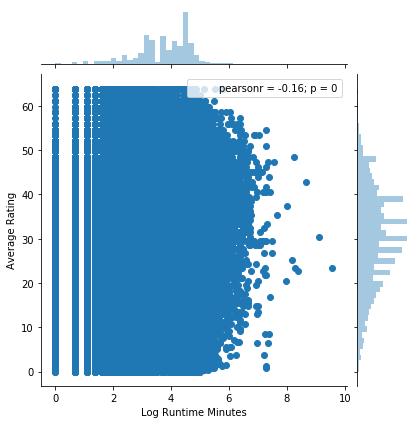

In [29]:
plt.figure(figsize=(20, 10))

g = sns.jointplot(np.log(df['runtimeMinutes'],
                         where=df['runtimeMinutes']>0),
                  df['bc_avg_rating'])

g.ax_joint.set_xlabel('Log Runtime Minutes')
g.ax_joint.set_ylabel('Average Rating');

Распределение рейтинга в зависимости от признака `isAdult`.

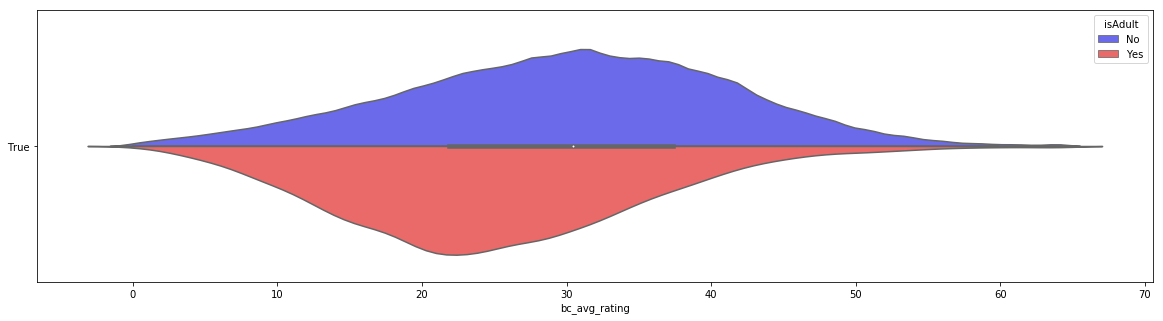

In [30]:
plt.figure(figsize=(20, 5))

sns.violinplot(df['bc_avg_rating'],
               pd.Series([True] * df.shape[0]),
               hue=df['isAdult'].map({0: 'No', 1: 'Yes'}),
               split=True,
               orient='h',
               palette='seismic');

### Почему и как можно преобразовать целевой признак

С учетом анализа и выводов выше считаю, что стоит работать с признаком, преобразованным по методу Бокса-Кокса.

## Выводы, инсайты, найденные зависимости

### Предположения о природе различных корреляций/пропусков/закономерностей и выбросов, найденных в предыдущих пунктах. Пояснение, почему они важны для решаемой задачи.

1. Благодаря анализу выбросов можно сделать гипотезу, что стоит взвесить количество голосов с учетом года релиза. И завести признак "Арифметическое среднее количества голосов в год". А вот абсолютное количество голосов исключить из данных, используемых для обучения модели.
2. Корреляции рейтинга по Пирсону с количественными признаками я не обнаружил. Посмотрим, сработает ли гипотеза, которая интуитивно кажется мне основной — зависимость рейтинга от того, какие люди участвуют в производстве картины.
3. Пропуски, как я описал выше, мы обработали.
4. Выбросы, которые мне удалось найти, оказались на деле не ошибками, а реальными данными.

Важность этих выводов, на мой взгляд, объясняется следующими пунктами:
- Линейная регрессия будет плохо работать, если нет корреляций (как в нашем случае). Значит, надо поискать зависимость с другими признаками (например, кто из людей участвовал в создании фильма) и попробовать построить дополнительные признаки, чтобы учесть наличие нелинейных зависимостей.
- Благодаря анализу была найдена такая зависимость, которая будет отражена в признаке "Арифметическое среднее количества голосов в год".

## Выбор метрики

С учетом системы рейтингов IMDb можно было бы рассмотреть задачу как многоклассовую one-against-all классификацию (с 91 классом: "10.0", "9.9", "9.8" и т. д. до "1.0"). Однако, интересно все же решить задачу регрессии, так как полученный с помощью такой модели результат затем не составит труда округлить до нужного числа.

Для регрессии я выбираю метрику MSE, среднеквадратичная ошибка. Хотя есть некоторое количество выбросов, оно все же довольно маленькое относительно всей выборки, а само распределение довольно близко к нормальному.

## Выбор модели

В этой задаче я планирую работать с линейной моделью.

Во-первых, у нас будет разреженная матрица: названия произведений, сценаристы, режиссеры, другие участники будут обработаны как токены.

Во-вторых, данных довольно много и хочется по возможности оптимизировать скорость обучения, например, с помощью SGDRegressor.

Как альтернативы можно было бы рассмотреть Lasso или Ridge. На основе своих прошлых экспериментов я думаю, что эти варианты будут медленнее, поэтому останавливаю свой выбор на SGDRegressor.

## Предобработка данных

### Создание новых признаков и описание этого процесса

Для начала создадим новый признак — среднее количество голосов в год. Поскольку данные были скачаны в 2018 году, используем этот год за точку отсчета. При этом будем считать, что фильмы, выпущенные в 2018 году, собрали все голоса за один год (т. е. год релиза будем вычитать из `2019`).

Пока модель не готова, нельзя сказать, насколько обоснованным является создание такого дополнительного признака. Зато ясно, что если один фильм набрал 10 голосов за 10 лет, а другой — столько же голосов за 1 год, я не хочу считать это как одинаковое количество голосов.

In [31]:
df['num_votes_yearly_avg'] = df['numVotes'] / (2019 - df['startYear'])

Информацию об абсолютном количестве голосов я не буду включать в модель, а вот `startYear` оставлю. `endYear` у большинства объектов тоже отсутствует (равен нулю), так что и его пока не буду включать.

Второй признак, который мне понадобится, это `titleTypeEncoded`. Я планирую использовать OHE преобразование с `titleType`, и OneHotEncoder ожидает получить числа, а не строки на вход. Поэтому предварительно надо преобразовать данные.

In [32]:
le = LabelEncoder()
df['titleTypeEncoded'] = le.fit_transform(df['titleType'])

### Разделение на train, valid и test части

Теперь, когда данные собраны и еще не прошли предобработку, стоит разделить выборку на обучающую, валидационную и тестовую. Поскольку корреляция (по Пирсону) рейтинга и года релиза практически отсутствует, данные можно спокойно перемешать. А тестовую часть просто возьму с конца. Такой способ выделения тестовой выборки обоснован следующим:
- количество объектов больше полумиллиона;
- год релиза практически не имеет никакой корреляции с целевой переменной по Пирсону.

In [33]:
TEST_SIZE = 0.2 # 20% выборки отведем для теста.
idx_split = df.shape[0] - int(df.shape[0] * TEST_SIZE)

Посмотрим на получившиеся распределения целевого признака в разных частях данных.

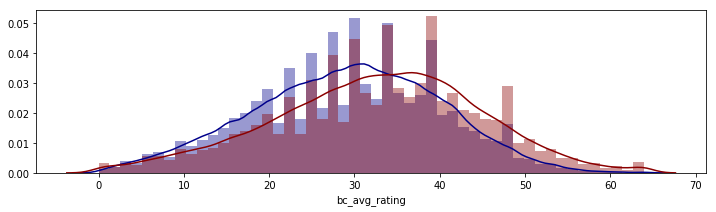

In [34]:
train_df = df.iloc[:idx_split]
holdout = df.iloc[idx_split:]

plt.figure(figsize=(12, 3))

sns.distplot(train_df['bc_avg_rating'],
             color='darkblue',
             label='Train and Valid Parts\' Target Distribution')
sns.distplot(holdout['bc_avg_rating'],
             color='darkred',
             label='Test Part\'s Target Distribution');

Идеально не совпадает, но примерно похоже. Теперь разделим обучающую выборку на train и valid части.

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df[[
        'titleTypeEncoded',
        'isAdult',
        'primaryTitle',
        'startYear',
        'directors',
        'writers',
        'principals',
        'runtimeMinutes',
        'num_votes_yearly_avg'
    ] + list(unique_genres)],
    train_df['bc_avg_rating'],
    test_size=0.3,
    random_state=17)

In [36]:
y_train_complete = train_df['bc_avg_rating']
y_holdout_true = holdout['bc_avg_rating']

### Масштабирование
Масштабировать буду количественные признаки: `runtimeMinutes`, `num_votes_yearly_avg`, `startYear`.

In [37]:
features_to_scale = [
    'runtimeMinutes',
    'num_votes_yearly_avg',
    'startYear'
]

scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])

X_train_scaled = scaler.transform(X_train[features_to_scale])
X_valid_scaled = scaler.transform(X_valid[features_to_scale])

In [38]:
X_holdout_scaled = scaler.transform(holdout[features_to_scale])

### OHE
OneHotEncode преобразование планирую только для `titleType`. Для `isAdult` оно не требуется, т. к. это и так бинарный признак. Для жанров тоже не требуется, потому что я их уже преобразовал ранее. И все же я включу эти колонки в текущее преобразование, потому что так мне удобнее с ними работать дальше.

In [39]:
features_to_ohe = [
    'titleTypeEncoded',
    'isAdult'
] + list(unique_genres)

ohe = OneHotEncoder()
ohe.fit(X_train[features_to_ohe])

X_train_ohe = ohe.transform(X_train[features_to_ohe])
X_valid_ohe = ohe.transform(X_valid[features_to_ohe])

In [40]:
X_holdout_ohe = ohe.transform(holdout[features_to_ohe])

### Обработка названий произведений и "имен" авторов
Имена взял в кавычки, т. к. хоть это и строки, на самом деле это идентификаторы в строковой форме.

In [41]:
title_vectorizer = CountVectorizer(
    ngram_range=(1,3),
    max_features=160000,
    stop_words='english')

title_vectorizer.fit(X_train['primaryTitle'])

X_train_title_cv = title_vectorizer.transform(X_train['primaryTitle'])
X_valid_title_cv = title_vectorizer.transform(X_valid['primaryTitle'])

In [42]:
directors_vectorizer = CountVectorizer(
    ngram_range=(1,2), # Возможно, совместно определенные пары выдают наилучший результат
    max_features=160000)

directors_vectorizer.fit(X_train['directors'])

X_train_dir_cv = directors_vectorizer.transform(X_train['directors'])
X_valid_dir_cv = directors_vectorizer.transform(X_valid['directors'])

In [43]:
writers_vectorizer = CountVectorizer(
    ngram_range=(1,2), # Аналогичная гипотеза про пары
    max_features=160000)

writers_vectorizer.fit(X_train['writers'])

X_train_wrt_cv = writers_vectorizer.transform(X_train['writers'])
X_valid_wrt_cv = writers_vectorizer.transform(X_valid['writers'])

In [44]:
principals_vectorizer = CountVectorizer(
    ngram_range=(1,3), # Похожая гипотеза, на этот раз, включая и тройки
    max_features=240000)

principals_vectorizer.fit(X_train['principals'])

X_train_ppl_cv = principals_vectorizer.transform(X_train['principals'])
X_valid_ppl_cv = principals_vectorizer.transform(X_valid['principals'])

In [45]:
X_holdout_title_cv = title_vectorizer.transform(holdout['primaryTitle'])
X_holdout_dir_cv = directors_vectorizer.transform(holdout['directors'])
X_holdout_wrt_cv = writers_vectorizer.transform(holdout['writers'])
X_holdout_ppl_cv = principals_vectorizer.transform(holdout['principals'])

Теперь соберем все вместе.

In [46]:
train_processed = hstack((
    X_train_scaled,
    X_train_ohe,
    X_train_title_cv,
    X_train_dir_cv,
    X_train_wrt_cv,
    X_train_ppl_cv
))

valid_processed = hstack((
    X_valid_scaled,
    X_valid_ohe,
    X_valid_title_cv,
    X_valid_dir_cv,
    X_valid_wrt_cv,
    X_valid_ppl_cv
))

In [47]:
holdout_processed = hstack((
    X_holdout_scaled,
    X_holdout_ohe,
    X_holdout_title_cv,
    X_holdout_dir_cv,
    X_holdout_wrt_cv,
    X_holdout_ppl_cv
))

### Кросс-валидация и настройка гиперпараметров модели

In [48]:
sgd_reg = SGDRegressor(alpha=0.0001,
                       loss='squared_loss',
                       max_iter=300,
                       tol=1e-3,
                       random_state=17)
sgd_reg.fit(train_processed, y_train)
y_pred = sgd_reg.predict(valid_processed);

In [49]:
mse = mean_squared_error(y_valid, y_pred)
mse_sqrt = mse ** 0.5
mse_sqrt_bc_reverse = reverse_boxcox(mse_sqrt, bc_lmbda)
print("MSE: {:.3f}\n\
Square root of MSE: {:.3f}\n\
Same with Reversed Box-Cox Transformation: {:.3f}".format(
    mse,
    mse_sqrt,
    mse_sqrt_bc_reverse
))

MSE: 65.807
Square root of MSE: 8.112
Same with Reversed Box-Cox Transformation: 3.898


Видно, что модель (с параметрами по умолчанию) вполне может ошибиться на 4 балла (при том, что расстояние между максимальной оценкой и минимальной — всего 10 баллов). Посмотрим, поможет ли кросс-валидация.

Я использую обычное KFold разбиение на 6 фолдов. Данных достаточно много, чтобы качество не сильно "скакало" на таком количестве фолдов. `shuffle=True`, т. к., как уже обсудили выше, мы не сильно зависим от времени.

На мой взгляд, у SGD в данном случае имеет смысл перебирать только гиперпараметр регуляризации, `alpha`. Его возможные значения подбираю в интервале от `1e-5` до `1e1`.

In [50]:
%%time

kf = KFold(6, shuffle=True, random_state=17)
params = {'alpha': np.logspace(-5, 1, 7)}

gscv = GridSearchCV(sgd_reg,
                    params,
                    scoring='neg_mean_squared_error',
                    cv=kf)
gscv.fit(train_processed, y_train);

C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Wall time: 5min 22s


In [51]:
print(gscv.best_params_)
print(gscv.best_score_)
print(reverse_boxcox((-1 * gscv.best_score_) ** 0.5, bc_lmbda))

{'alpha': 1e-05}
-67.88085032623756
3.9244036483964506


Как видно, кросс-валидация сильно не помогла.

## Построение кривых валидации и обучения

In [52]:
%%time

alphas = np.logspace(-5, 1, 7)

train_scores_vc, test_scores_vc = validation_curve(gscv.best_estimator_,
                                             train_processed,
                                             y_train,
                                             'alpha',
                                             alphas,
                                             cv=kf,
                                             scoring='neg_mean_squared_error')

train_sizes = np.linspace(0.1, 1, 7)

train_size, train_scores_lc, test_scores_lc = learning_curve(gscv.best_estimator_,
                                                       train_processed,
                                                       y_train,
                                                       train_sizes=train_sizes,
                                                       cv=kf,
                                                       scoring='neg_mean_squared_error')
# ~14 min

C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ilyav\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\ilyav\Anaconda3\lib\site-packag

Wall time: 13min 22s


In [53]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

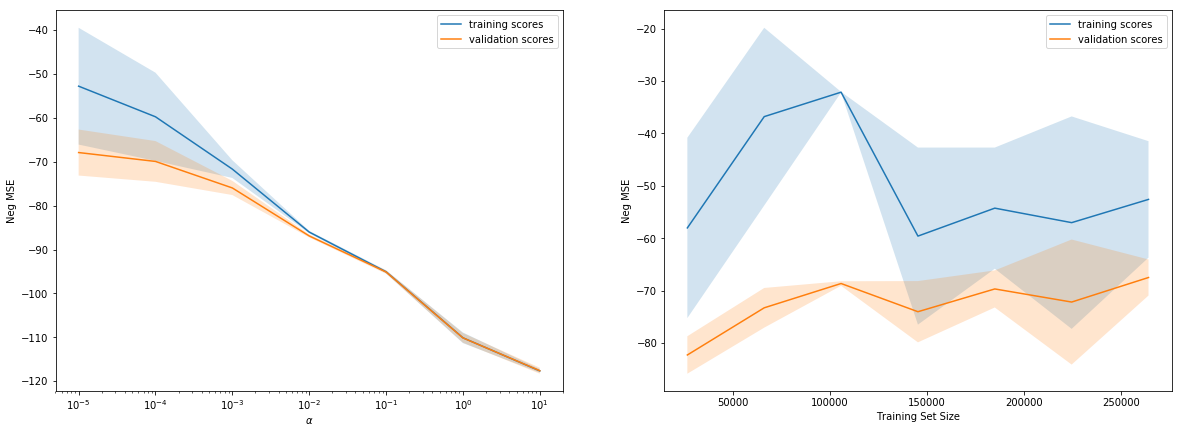

In [54]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_with_err(alphas, train_scores_vc, label='training scores')
plot_with_err(alphas, test_scores_vc, label='validation scores')
plt.xlabel(r'$\alpha$')
plt.xscale('log')
plt.ylabel('Neg MSE')
plt.legend()

plt.subplot(122)
plot_with_err(train_size, train_scores_lc, label='training scores')
plot_with_err(train_size, test_scores_lc, label='validation scores')
plt.xlabel('Training Set Size')
plt.ylabel('Neg MSE')
plt.legend();

### Интерпретация

1. Чем меньше alpha, тем лучше скор, но и выше разброс. Конечно, выбирать значение регуляризации, находящееся на границе перебора через GridSearch, не рекомендуется. Но и подбирать слишком маленькое alpha тоже не рекомендуется, чтобы модель не переобучилась.

2. В начале learning curve мы видим небольшой пик. Я думаю, это свидетельствует о переобучении, так как ошибки в трейне и на валидации отличаются довольно сильно по сравнению с правой частью графика. А справа разница между скорами снижается и стабилизируется на более-менее постоянном значении. Схождение могло бы свидетельствовать о недообучении. Из этого можно сделать вывод, что можно попробовать добавить больше данных без изменения модели, так как значения скоров (пока) не сошлись.

## Прогноз для тестовой или отложенной выборки

In [55]:
%%time

train_complete = vstack((train_processed,
                         valid_processed))

gscv.best_estimator_.fit(train_complete, y_train_complete)

y_holdout_pred = gscv.best_estimator_.predict(holdout_processed)

# ~30s

Wall time: 32.7 s


### Результаты на тестовой выборке

In [56]:
mse_h = mean_squared_error(y_holdout_true, y_holdout_pred)
mse_h_sqrt = mse_h ** 0.5
mse_h_sqrt_bc_reverse = reverse_boxcox(mse_h_sqrt, bc_lmbda)
print("MSE: {:.3f}\n\
Square root of MSE: {:.3f}\n\
Same with Reversed Box-Cox Transformation: {:.3f}".format(
    mse_h,
    mse_h_sqrt,
    mse_h_sqrt_bc_reverse
))

MSE: 163.056
Square root of MSE: 12.769
Same with Reversed Box-Cox Transformation: 4.773


После того, как мы опробовали модель на holdout выборке, видно, что качество результата немного упало. Если на валидации ошибка могла быть в среднем около 3.92 балла, то для holdout это значение составляет уже 4.773. Думаю, частично это можно объяснить тем, что распределение holdout'а немного отличается от той части, на которой производился перебор альфы.

## Выводы

### Ценность решения
Из результатов тестов видно, что если мы будем всем фильмам предсказывать оценку 5.5 баллов `((10 - 1) / 2) + 1`, то качество такого предсказания будет не сильно отличаться от качества работы построенной модели. Поэтому можно заключить, что модель в таком виде не представляет такой ценности, которую хотелось бы создать с учетом целей, обозначенных во введении.

### Возможности применения
В силу крайне низкого качества модели ей остается шуточное применение. В данных из `./data/name.basics.tsv/data.tsv` можно найти идентификаторы интересующих вас режиссеров, сценаристов и других профессионалов. Придумать заголовок для вашего будущего фильма. И подставить эти значения на вход модели, чтобы узнать, как хорошо ее примут зрители :)

### Дальнейшие пути развития и улучшения решения
Несмотря на текущие результаты, есть надежда, что поставленных целей все же можно достичь с помощью доработок модели. Для дальнейшего усовершенствования модели имеет смысл поработать следующие шаги.
1. Из name.basics позаимствовать информацию о других работах каждого участника (колонка `knownForTitles`), и о рейтингах этих работ (при условии, конечно, их наличия в обучающей выборке, чтобы избежать ликов). Это имеет смысл, если верна гипотеза, что у каждого человека работа получается примерно одного уровня (что далеко не всегда верно).
2. На основе рейтингов других работ каждого участника и их года релиза можно построить динамику и использовать ее, а не среднее арифметическое из п. 1.
3. Кроме того, имеет смысл считать статистику от таких рейтингов для всей команды оцениваемого фильма. Например, насколько сильно отличаются прошлые успехи членов команды. Например, если отличия небольшие и при этом рейтинги были высокие, интуитивно кажется, что и на этот раз все будет хорошо.
4. Возможно, имеет смысл парсить открытые источники для получения информации о бюджете на создание фильма и о кассовых сборах. Конечно, информацию о кассовых сборах использовать в такой модели не очень интересно, ведь эта информация неизвестна для фильмов, которые только планируются. Зато информацию о бюджете использовать разумно.
5. Наконец, было бы здорово использовать информацию о доминирующих цветах в палитре фильма.

## Лицензионная информация об использованных данных

Information courtesy of<br/>
IMDb<br/>
(http://www.imdb.com).<br/>
Used with permission.<br/>